# Cálculo de la frecuencia cardiaca a partir de datos crudos

Esta vez me baso en el artículo que nos pasó Pablo que describe lo que se espera de hacer con el pulsioxímetro

El artículo describe varios métodos para calcular la frecuencia cardíaca a partir de señales PPG (fotopletismografía). Se detallan tres enfoques principales:

**Método de Cruce por Umbral**:

- Se filtra la señal con un **paso alto** para eliminar la **deriva**.

- Se establecen umbrales (positivo y negativo) basados en una fracción del **valor máximo de la señal**.

- Se cuenta **cuántas veces la señal cruza los umbrales** para estimar la frecuencia cardíaca.

**Método de Ventana:**

- Se mantiene una ventana de tamaño dinámico (2/3 del período estimado del pulso).

- Si un valor se mantiene como un máximo o mínimo en toda la ventana, se considera un pico o valle real.

- Se evita detectar picos falsos debido a la muesca dicrótica.

**Método de Fusión:**

- Se combinan los dos métodos anteriores.

- Si la estimación de la ventana difiere más del 25% con el cruce por umbral, se descarta.

- Se usa un filtro de Kalman para suavizar las mediciones y eliminar valores atípicos.

## Método de cruce por umbral

Pasos:
    
1. Cargar el archivo CSV y visualizar los datos.

2. Filtrar la señal con un filtro pasaaltos para eliminar la deriva.

3. Calcular los umbrales como una fracción del máximo de la señal IR.

4. Contar los cruces de umbral y estimar la frecuencia cardíaca.

5. Comparar el resultado con la frecuencia de referencia (91 BPM).

### 1. Cargar el archivo

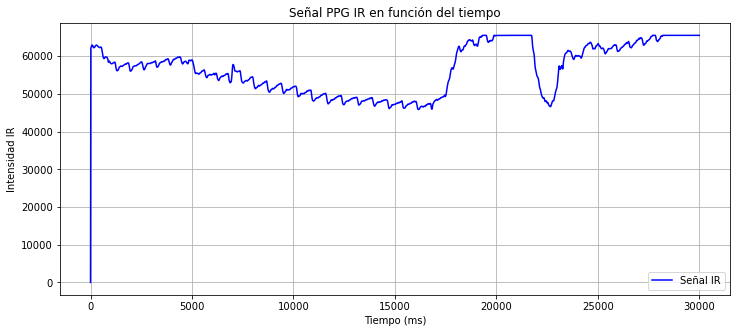

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

_file_path = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_77_2.csv"
df = pd.read_csv(file_path, delimiter=";")


# Graficar la señal IR original
plt.figure(figsize=(12, 5))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="blue")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.title("Señal PPG IR en función del tiempo")
plt.legend()
plt.grid(True)
plt.show()

### 2. Aplicar un filtro pasaaltos para eliminar la deriva

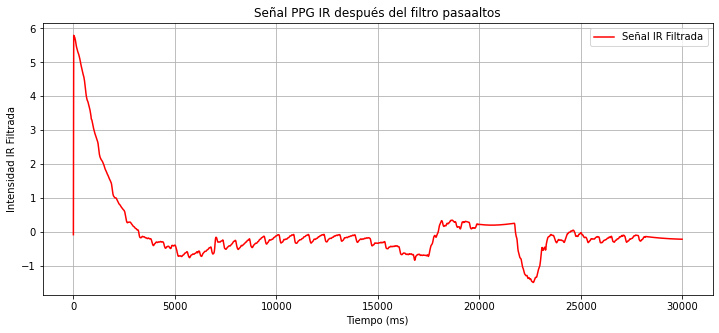

In [2]:
def butter_highpass_filter(data, cutoff=0.5, fs=60, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

fs = 60  # Frecuencia de muestreo estimada (Hz)
filtered_ir = butter_highpass_filter(df["IR"], cutoff=0.1, fs=fs)
filtered_ir = (filtered_ir - np.mean(filtered_ir)) / np.std(filtered_ir)

# Graficar la señal filtrada
plt.figure(figsize=(12, 5))
plt.plot(df["Tiempo (ms)"], filtered_ir, label="Señal IR Filtrada", color="red")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR Filtrada")
plt.title("Señal PPG IR después del filtro pasaaltos")
plt.legend()
plt.grid(True)
plt.show()

### 3. Calcular los umbrales

In [3]:
threshold_high = 0.3 * np.max(filtered_ir) # Umbral alto (50% del máx.)
threshold_low = -threshold_high            # Umbral bajo
print(threshold_high)
print(threshold_low)

1.7390492711447638
-1.7390492711447638


### 4. Contar los cruces de umbral

In [4]:
crossings = 0
for i in range(1, len(filtered_ir)):
    if (filtered_ir[i-1] < threshold_high and filtered_ir[i] >= threshold_high) or \
       (filtered_ir[i-1] > threshold_low and filtered_ir[i] <= threshold_low):
        crossings += 1

# Cada latido tiene dos cruces, así que dividimos entre 2 y calculamos BPM
heart_rate = (crossings / 2) * (fs / len(filtered_ir)) * 60


### 5. Comparar con la referencia


Frecuencia cardíaca estimada: 1.00 BPM
Frecuencia de referencia: 91 BPM
Error: 90.00 BPM


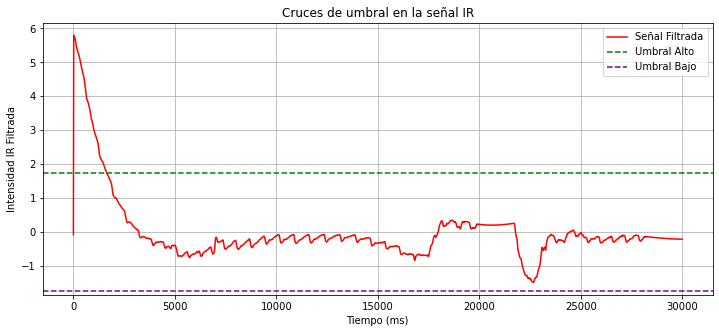

In [5]:
print(f"\nFrecuencia cardíaca estimada: {heart_rate:.2f} BPM")
print(f"Frecuencia de referencia: 91 BPM")
error = abs(heart_rate - 91)
print(f"Error: {error:.2f} BPM")

# Mostrar los umbrales en la gráfica
plt.figure(figsize=(12, 5))
plt.plot(df["Tiempo (ms)"], filtered_ir, label="Señal Filtrada", color="red")
plt.axhline(y=threshold_high, color="green", linestyle="--", label="Umbral Alto")
plt.axhline(y=threshold_low, color="purple", linestyle="--", label="Umbral Bajo")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR Filtrada")
plt.title("Cruces de umbral en la señal IR")
plt.legend()
plt.grid(True)
plt.show()

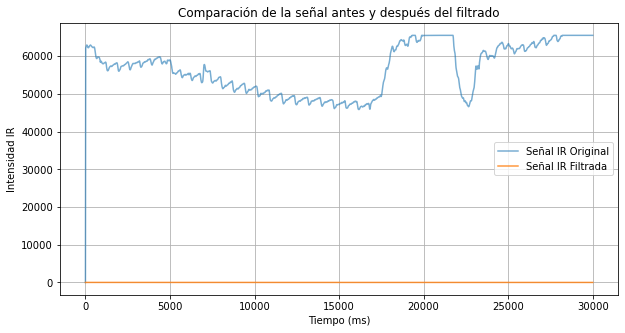

In [6]:
plt.figure(figsize=(10,5))
plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR Original", alpha=0.6)
plt.plot(df["Tiempo (ms)"], filtered_ir, label="Señal IR Filtrada", alpha=0.8)
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.legend()
plt.title("Comparación de la señal antes y después del filtrado")
plt.grid()
plt.show()


## Método de la ventana

Pasos:
- Dividir la señal en ventanas de tiempo (por ejemplo, 5 segundos).
- Calcular la frecuencia cardíaca en cada ventana usando la Transformada de Fourier o detección de picos.
- Promediar los valores obtenidos para estimar la frecuencia cardíaca global.

1. Aplica un filtro pasaaltos para eliminar la deriva.
2. Divide la señal en ventanas de 5 segundos.
3. Detecta picos en cada ventana usando find_peaks().
4. Calcula la frecuencia cardíaca en cada ventana y luego promedia los resultados.
5. Plotea la última ventana con los picos detectados.

Frecuencia cardíaca estimada: 78.00 BPM
Frecuencia de referencia: 77 BPM
Error: 1.00 BPM


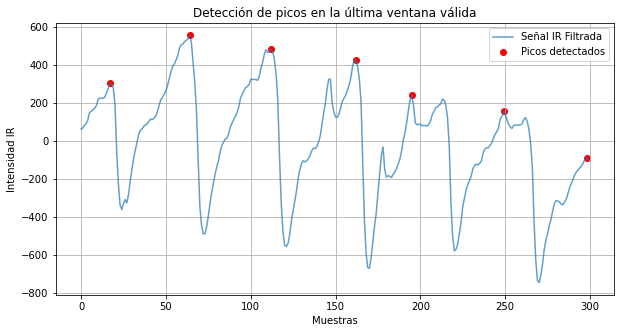

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Cargar datos
df = pd.read_csv("C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_77_2.csv", delimiter=";")

# Configuración
fs = 60  # Frecuencia de muestreo en Hz
window_size = 5 * fs  # Ventana de 5 segundos

# Filtro pasaaltos
def butter_highpass_filter(data, cutoff=0.5, fs=fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

df["IR_Filtrado"] = butter_highpass_filter(df["IR"], cutoff=0.1, fs=fs)

# Dividir en ventanas y calcular la frecuencia cardíaca
hr_values = []

for start in range(0, len(df), window_size):
    window = df["IR_Filtrado"].iloc[start:start + window_size]
    
    if len(window) < window_size:
        break  # Ignorar ventanas incompletas

    # Detección de picos
    peaks, _ = find_peaks(window, distance=fs*0.5)  # Al menos 0.5s entre picos

    # Calcular frecuencia cardíaca
    if len(peaks) > 1:
        hr = len(peaks) * (60 / (len(window) / fs))
        hr_values.append(hr)

# Promediar los valores obtenidos
hr_estimated = np.mean(hr_values) if hr_values else 0

# Mostrar resultados
print(f"Frecuencia cardíaca estimada: {hr_estimated:.2f} BPM")
print(f"Frecuencia de referencia: 77 BPM")
print(f"Error: {abs(hr_estimated - 77):.2f} BPM")

# Visualizar la detección de picos en la última ventana válida
if hr_values:
    last_window = df["IR_Filtrado"].iloc[-window_size:]
    peaks, _ = find_peaks(last_window, distance=fs*0.5)

    plt.figure(figsize=(10,5))
    plt.plot(last_window.values, label="Señal IR Filtrada", alpha=0.7)

    if len(peaks) > 0:
        plt.scatter(peaks, last_window.iloc[peaks], color="red", label="Picos detectados")

    plt.xlabel("Muestras")
    plt.ylabel("Intensidad IR")
    plt.legend()
    plt.title("Detección de picos en la última ventana válida")
    plt.grid()
    plt.show()

Frecuencia cardíaca estimada: 80.00 BPM
Frecuencia de referencia: 81 BPM
Error: 1.00 BPM


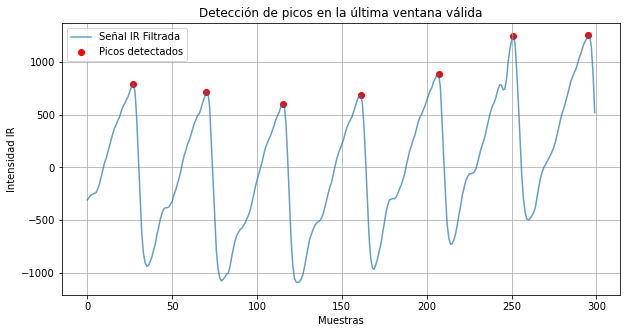

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Cargar datos
df = pd.read_csv("C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_98_81.csv", delimiter=";")

# Configuración
fs = 60  # Frecuencia de muestreo en Hz
window_size = 5 * fs  # Ventana de 5 segundos

# Filtro pasaaltos
def butter_highpass_filter(data, cutoff=0.5, fs=fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

df["IR_Filtrado"] = butter_highpass_filter(df["IR"], cutoff=0.1, fs=fs)

# Dividir en ventanas y calcular la frecuencia cardíaca
hr_values = []

for start in range(0, len(df), window_size):
    window = df["IR_Filtrado"].iloc[start:start + window_size]
    
    if len(window) < window_size:
        break  # Ignorar ventanas incompletas

    # Detección de picos
    peaks, _ = find_peaks(window, distance=fs*0.5)  # Al menos 0.5s entre picos

    # Calcular frecuencia cardíaca
    if len(peaks) > 1:
        hr = len(peaks) * (60 / (len(window) / fs))
        hr_values.append(hr)

# Promediar los valores obtenidos
hr_estimated = np.mean(hr_values) if hr_values else 0

# Mostrar resultados
print(f"Frecuencia cardíaca estimada: {hr_estimated:.2f} BPM")
print(f"Frecuencia de referencia: 81 BPM")
print(f"Error: {abs(hr_estimated - 81):.2f} BPM")

# Visualizar la detección de picos en la última ventana válida
if hr_values:
    last_window = df["IR_Filtrado"].iloc[-window_size:]
    peaks, _ = find_peaks(last_window, distance=fs*0.5)

    plt.figure(figsize=(10,5))
    plt.plot(last_window.values, label="Señal IR Filtrada", alpha=0.7)

    if len(peaks) > 0:
        plt.scatter(peaks, last_window.iloc[peaks], color="red", label="Picos detectados")

    plt.xlabel("Muestras")
    plt.ylabel("Intensidad IR")
    plt.legend()
    plt.title("Detección de picos en la última ventana válida")
    plt.grid()
    plt.show()

## Método de fusión (combinación de ambos)

Combina los métodos de umbral y ventana para mejorar la precisión de la detección de la frecuencia cardíaca. Este método es especialmente útil para evitar problemas cuando uno de los métodos falla, como cuando el cálculo de la ventana se bloquea en una subarmónica.

Pasos:

- Usa el método de umbral para obtener una estimación inicial de la frecuencia cardíaca.

- Usa el método de ventana para obtener una segunda estimación.

- Fusiona los resultados:

    - Si el método de ventana es demasiado diferente del de umbral (más del 25%), se descarta la estimación de la ventana.

    - Si ambos métodos coinciden dentro de un 25%, se considera el valor fusionado.

- Ajustes adicionales:
    - **Kalman filter** para eliminar outliers y suavizar los resultados.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Cargar datos
df = pd.read_csv("C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos crudos/save_log2/raw_data_95_77_2.csv", delimiter=";")

# 📌 Configuración
fs = 60  # Frecuencia de muestreo en Hz
window_size = 10 * fs  # Ventana de 10 segundos

# 📌 Filtro pasaaltos
def butter_highpass_filter(data, cutoff=0.05, fs=fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

df["IR_Filtrado"] = butter_highpass_filter(df["IR"], cutoff=0.05, fs=fs)

# 📌 Función para el método de umbral
def threshold_method(data):
    threshold_high = 0.3 * np.max(data)
    threshold_low = -threshold_high
    crossings = 0
    for i in range(1, len(data)):
        if (data[i-1] < threshold_high and data[i] >= threshold_high) or (data[i-1] > threshold_low and data[i] <= threshold_low):
            crossings += 1
    return (crossings / 2) * (60 / (len(data) / fs))  # Frecuencia cardíaca estimada

# 📌 Función para el método de ventana
def window_method(data):
    peaks, _ = find_peaks(data, height=0.2 * np.max(data), distance=fs*0.5)  # Al menos 0.5s entre picos
    return len(peaks) * (60 / (len(data) / fs))

# 📌 Dividir en ventanas y fusionar resultados
hr_values_fusion = []

for start in range(0, len(df) - window_size, window_size):  # Ajuste en el rango
    window = df["IR_Filtrado"].iloc[start:start + window_size]
    
    if len(window) < window_size:
        break  # Ignorar ventanas incompletas

    # Método de umbral
    hr_threshold = threshold_method(window)
    
    # Método de ventana
    hr_window = window_method(window)
    
    # Fusionar resultados
    if abs(hr_threshold - hr_window) <= 0.25 * hr_threshold:
        hr_fused = (hr_threshold + hr_window) / 2
    else:
        hr_fused = hr_window if abs(hr_window - hr_threshold) > 0.25 * hr_threshold else hr_threshold
    
    hr_values_fusion.append(hr_fused)

# 📌 Promediar los valores obtenidos
hr_estimated_fusion = np.mean(hr_values_fusion) if hr_values_fusion else 0

# 📌 Mostrar resultados
print(f"Frecuencia cardíaca estimada por fusión: {hr_estimated_fusion:.2f} BPM")
print(f"Frecuencia de referencia: 91 BPM")
print(f"Error: {abs(hr_estimated_fusion - 91):.2f} BPM")

# 📌 Visualizar la detección de picos en la última ventana válida
if hr_values_fusion:
    last_window = df["IR_Filtrado"].iloc[-window_size:]
    peaks, _ = find_peaks(last_window, height=0.2 * np.max(last_window), distance=fs*0.5)

    plt.figure(figsize=(10,5))
    plt.plot(last_window.values, label="Señal IR Filtrada", alpha=0.7)

    if len(peaks) > 0:
        plt.scatter(peaks, last_window.iloc[peaks], color="red", label="Picos detectados")

    plt.xlabel("Muestras")
    plt.ylabel("Intensidad IR")
    plt.legend()
    plt.title("Detección de picos en la última ventana válida")
    plt.grid()
    plt.show()

KeyError: 0